# Q2

In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# Allocate GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

GPU found
1 Physical GPUs, 1 Logical GPUs


### Import libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from glob import glob
from PIL import Image
import seaborn as sns

import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras.layers import Input, Conv2D, ConvLSTM2D, BatchNormalization, Dense, Flatten, Reshape, Lambda, Subtract, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras.backend as K

### Download dataset

In [ ]:
!wget -O hockeyfights.zip https://www.dropbox.com/sh/pmqpxc6bbckwd1j/AAAh5iUjDRiDEg6CEHHSbqDna?dl=0
!unzip hockeyfights.zip -d hockeyfights

## 3.4: Data Pre-processing

### Create Directories

In [4]:
!rm -rf frames
!rm -rf nonviolence_sample
!rm -rf violence_sample

path = '/content/hockeyfights'
violence_sample = '/content/violence_sample'
nonviolence_sample = '/content/nonviolence_sample'

if not os.path.exists(violence_sample):
    os.makedirs(violence_sample)
if not os.path.exists(nonviolence_sample):
    os.makedirs(nonviolence_sample)

### Create dataloader to save frames of videos

In [5]:
class DataLoader(Sequence):
    def __init__(self, files_list, folder_path, batch_size=2, num_frames=10, img_height=256, img_width=256):
        self.files_list = files_list
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.img_height = img_height
        self.img_width = img_width
        self.labels = [0 if f.startswith('no') else 1 for f in files_list]
    def __len__(self):
        return int(np.ceil(len(self.files_list) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_files = self.files_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        batch_y = []
        
        for index, filename in enumerate(batch_files):

            label = 0 if filename.startswith('no') else 1

            # Load the video and extract frames
            cap = cv2.VideoCapture(os.path.join(self.folder_path, filename))

            # Calculate number of frames in video
            num_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Calculate frame index interval for sampling 10 frames
            frame_index_interval = int(num_frames_in_video/self.num_frames)

            # Extract frames and save as images
            frames = []

            for i in range(self.num_frames):
              # Find current frame
                success, frame = cap.read()
                if not success:
                    break

                # Find adjacent frame
                next_success, next_frame = cap.read()
                if not next_success:
                    break            
                    
                # Calculate subtraction of frame and next_frame
                sub_frame = cv2.absdiff(frame, next_frame)
                frames.append(sub_frame)

                # You can change index according to batch_size to see another example here
                if index == 0 and label == 1:
                    cv2.imwrite(os.path.join(violence_sample, f'subtractional_result_{i}.jpg'), sub_frame)
                elif index == 0 and label == 0:
                    cv2.imwrite(os.path.join(nonviolence_sample, f'subtractional_result_{i}.jpg'), sub_frame) 

                # Skip frames
                if frame_index_interval > 2:
                    for _ in range(frame_index_interval-2):
                        cap.grab()
                elif frame_index_interval == 2:
                    for _ in range(frame_index_interval-1):
                        cap.grab()
                elif frame_index_interval <= 1:
                    for _ in range(frame_index_interval):
                        cap.grab()

            # Release video capture object
            cap.release()

            frames = np.array(frames)

            # Data augmentation on each frame difference
            frames_aug = np.zeros((self.num_frames, self.img_height, self.img_width, 3))
            for i in range(frames.shape[0]):
                img = frames[i]

                # Crop 15% of each side of the image
                crop_size = int(0.15 * min(img.shape[:2]))
                img = img[crop_size:-crop_size, crop_size:-crop_size]

                # Resize image to (256, 256, 3)
                img = cv2.resize(img, (self.img_height, self.img_width))

                # Randomly flip horizontally and vertically
                if np.random.random() < 0.5:
                    img = cv2.flip(img, 0)
                if np.random.random() < 0.5:
                    img = cv2.flip(img, 1)

                # Normalize to make images centered around mean 0 and variance unity
                img = img.astype(np.float32)
                mean = np.mean(img)
                std = np.std(img)
                img -= mean
                img /= std
                frames_aug[i] = img

            batch_x.append(frames_aug)
            batch_y.append(label)

        # Return the batch data and labels
        return np.array(batch_x), np.array(batch_y)

    def get_labels(self):
        return self.labels

In [6]:
num_frames = 10
height = 256
width = 256
random_state = 42
test_size = 0.2
val_size = 0.25 # 0.25 * 0.2 = 0.05

files_list = [f for f in os.listdir(path) if f.endswith('.avi')]

files_dict = {f: 0 if f.startswith('no') else 1 for f in files_list}

train_files, test_files = train_test_split(list(files_dict.keys()), test_size=test_size,
                                                      random_state=random_state, stratify=list(files_dict.values()))

test_dict = {f: 0 if f.startswith('no') else 1 for f in test_files}

test_files, val_files = train_test_split(list(test_dict.keys()), test_size=val_size,
                                                    random_state=random_state, stratify=list(test_dict.values()))

# Create the training, validation, and test data loaders
train_loader = DataLoader(files_list=train_files, folder_path=path, batch_size=2, num_frames=num_frames, img_height=height, img_width=width)
val_loader = DataLoader(files_list=val_files, folder_path=path, batch_size=2, num_frames=num_frames, img_height=height, img_width=width)
test_loader = DataLoader(files_list=test_files, folder_path=path, batch_size=2, num_frames=num_frames, img_height=height, img_width=width)

## 2. Network Architecture

### Metrics

In [7]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def accuracy(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total = K.sum(K.round(K.clip(y_true + (1 - y_true), 0, 1)))
    accuracy = (true_positives + true_negatives) / total
    return accuracy

### Define the model

In [8]:
# Define the input shape
input_shape = (num_frames, height, width, 3)

# Load the pre-trained ResNet50 model
resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Define the ConvLSTM layer
convlstm = tf.keras.layers.ConvLSTM2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', return_sequences=False)

# Define the fully connected layers
fc1 = tf.keras.layers.Dense(1000, activation='relu')
fc2 = tf.keras.layers.Dense(256, activation='relu')
fc3 = tf.keras.layers.Dense(10, activation='relu')
fc4 = tf.keras.layers.Dense(1, activation='sigmoid')

# Define the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.TimeDistributed(resnet))
model.add(convlstm)
model.add(BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(fc1)
model.add(fc2)
model.add(fc3)
model.add(fc4)

# Define the RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[accuracy, precision,
                                                                         recall, f1_score])

# Print the model summary
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 8, 8, 2048)   23587712  
 ibuted)                                                         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 8, 8, 256)         21234688  
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 1000)              16385000  
                                                         

In [9]:
# Define the early stopping callback
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)

# Define the learning rate schedule
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model using the DataLoader
history = model.fit(train_loader, epochs=50, validation_data=val_loader,
                     callbacks=[earlystop_callback, lr_schedule])

Epoch 1/50
400/400 [==============================] - 292s 610ms/step - loss: 0.5067 - accuracy: 0.7937 - precision: 0.6387 - recall: 0.6062 - f1_score: 0.6092 - val_loss: 0.0268 - val_accuracy: 1.0000 - val_precision: 0.6800 - val_recall: 0.6800 - val_f1_score: 0.6800 - lr: 1.0000e-04
Epoch 2/50
400/400 [==============================] - 242s 605ms/step - loss: 0.3678 - accuracy: 0.8737 - precision: 0.6837 - recall: 0.6600 - f1_score: 0.6633 - val_loss: 0.1285 - val_accuracy: 0.9800 - val_precision: 0.6800 - val_recall: 0.6800 - val_f1_score: 0.6800 - lr: 1.0000e-04
Epoch 3/50
400/400 [==============================] - 242s 605ms/step - loss: 0.3355 - accuracy: 0.8938 - precision: 0.6925 - recall: 0.6812 - f1_score: 0.6800 - val_loss: 0.0579 - val_accuracy: 0.9800 - val_precision: 0.6800 - val_recall: 0.6600 - val_f1_score: 0.6667 - lr: 1.0000e-04
Epoch 4/50
400/400 [==============================] - 242s 605ms/step - loss: 0.2696 - accuracy: 0.9262 - precision: 0.7063 - recall: 0.695

### Plot accuracy, recall, precision and f1 score

In [10]:
def plot_accuracy(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()    

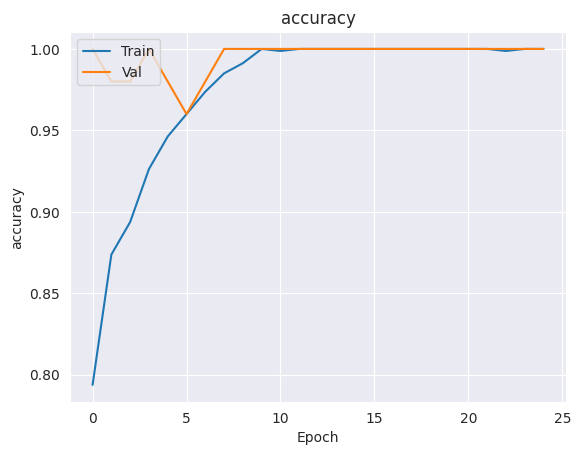

In [11]:
plot_accuracy(history)

In [12]:
def plot_loss(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()  

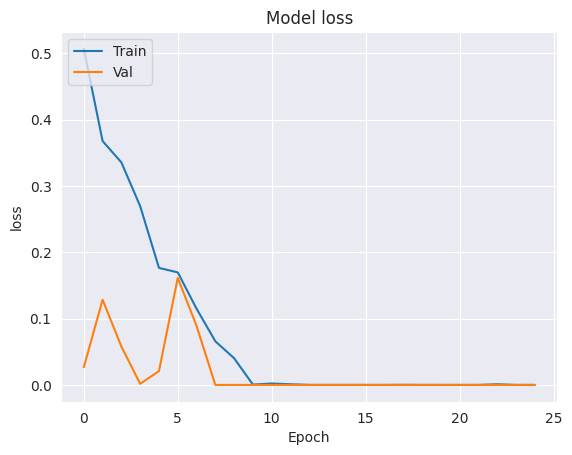

In [13]:
plot_loss(history)

In [14]:
def plot_precision(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('precision')
    plt.ylabel('precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()  

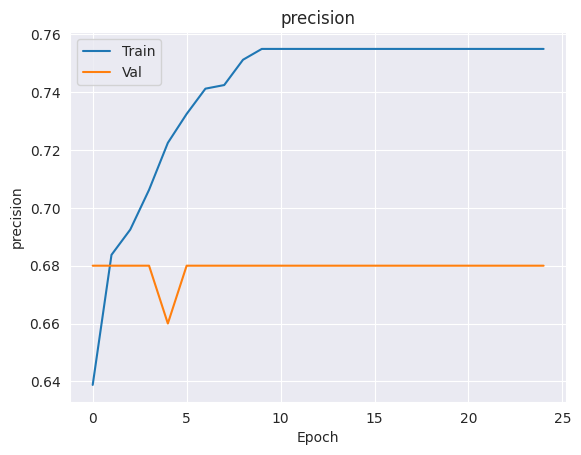

In [15]:
plot_precision(history)

In [16]:
def plot_recall(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('recall')
    plt.ylabel('recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()  

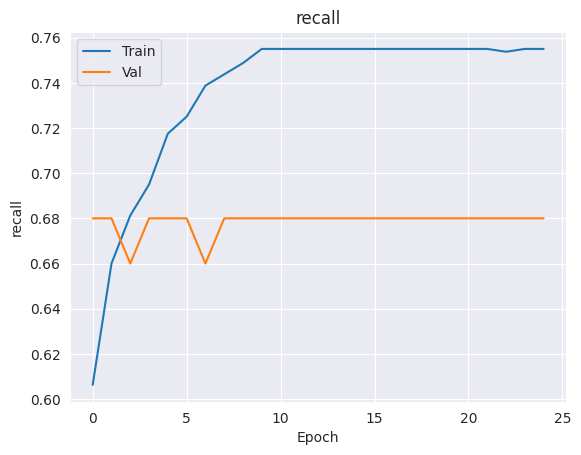

In [17]:
plot_recall(history)

In [18]:
def plot_f1_score(history):
  
    sns.set_style("darkgrid")
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('f1_score')
    plt.ylabel('f1_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()  

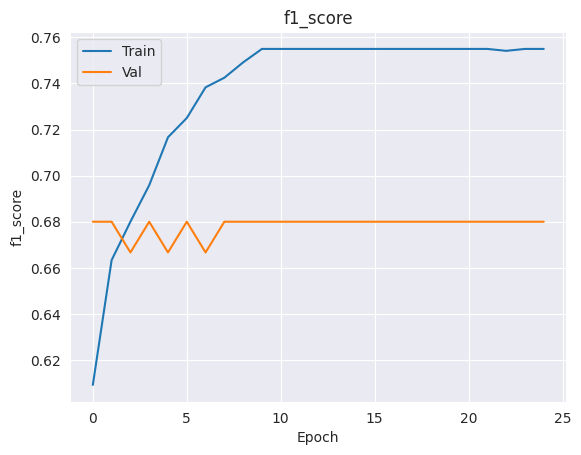

In [19]:
plot_f1_score(history)

### Evaluate the model with test dataloader

In [20]:
test_loss, test_acc, test_precision, test_recall, test_f1_score = model.evaluate(test_loader)

75/75 [==============================] - 12s 155ms/step - loss: 0.8909 - accuracy: 0.9400 - precision: 0.7333 - recall: 0.7400 - f1_score: 0.7333


### Show confusion matrix

In [21]:
# Get the model predictions and true labels for the training set
train_pred = model.predict(train_loader)
train_pred = [1 if p > 0.5 else 0 for p in train_pred]
train_true = train_loader.get_labels()

# Get the model predictions and true labels for the validation set
val_pred = model.predict(val_loader)
val_pred = [1 if p > 0.5 else 0 for p in val_pred]
val_true = val_loader.get_labels()

# Get the model predictions and true labels for the test set
test_pred = model.predict(test_loader)
test_pred = [1 if p > 0.5 else 0 for p in test_pred]
test_true = test_loader.get_labels()

# Compute the confusion matrices
train_cm = confusion_matrix(train_true, train_pred)
val_cm = confusion_matrix(val_true, val_pred)
test_cm = confusion_matrix(test_true, test_pred)

print('Training set confusion matrix:')
print(train_cm)
print('Validation set confusion matrix:')
print(val_cm)
print('Test set confusion matrix:')
print(test_cm)

75/75 [==============================] - 11s 150ms/step
Training set confusion matrix:
[[400   0]
 [  2 398]]
Validation set confusion matrix:
[[25  0]
 [ 0 25]]
Test set confusion matrix:
[[72  3]
 [ 5 70]]


### Plot samples
Plot 10 frames of a video from each class 

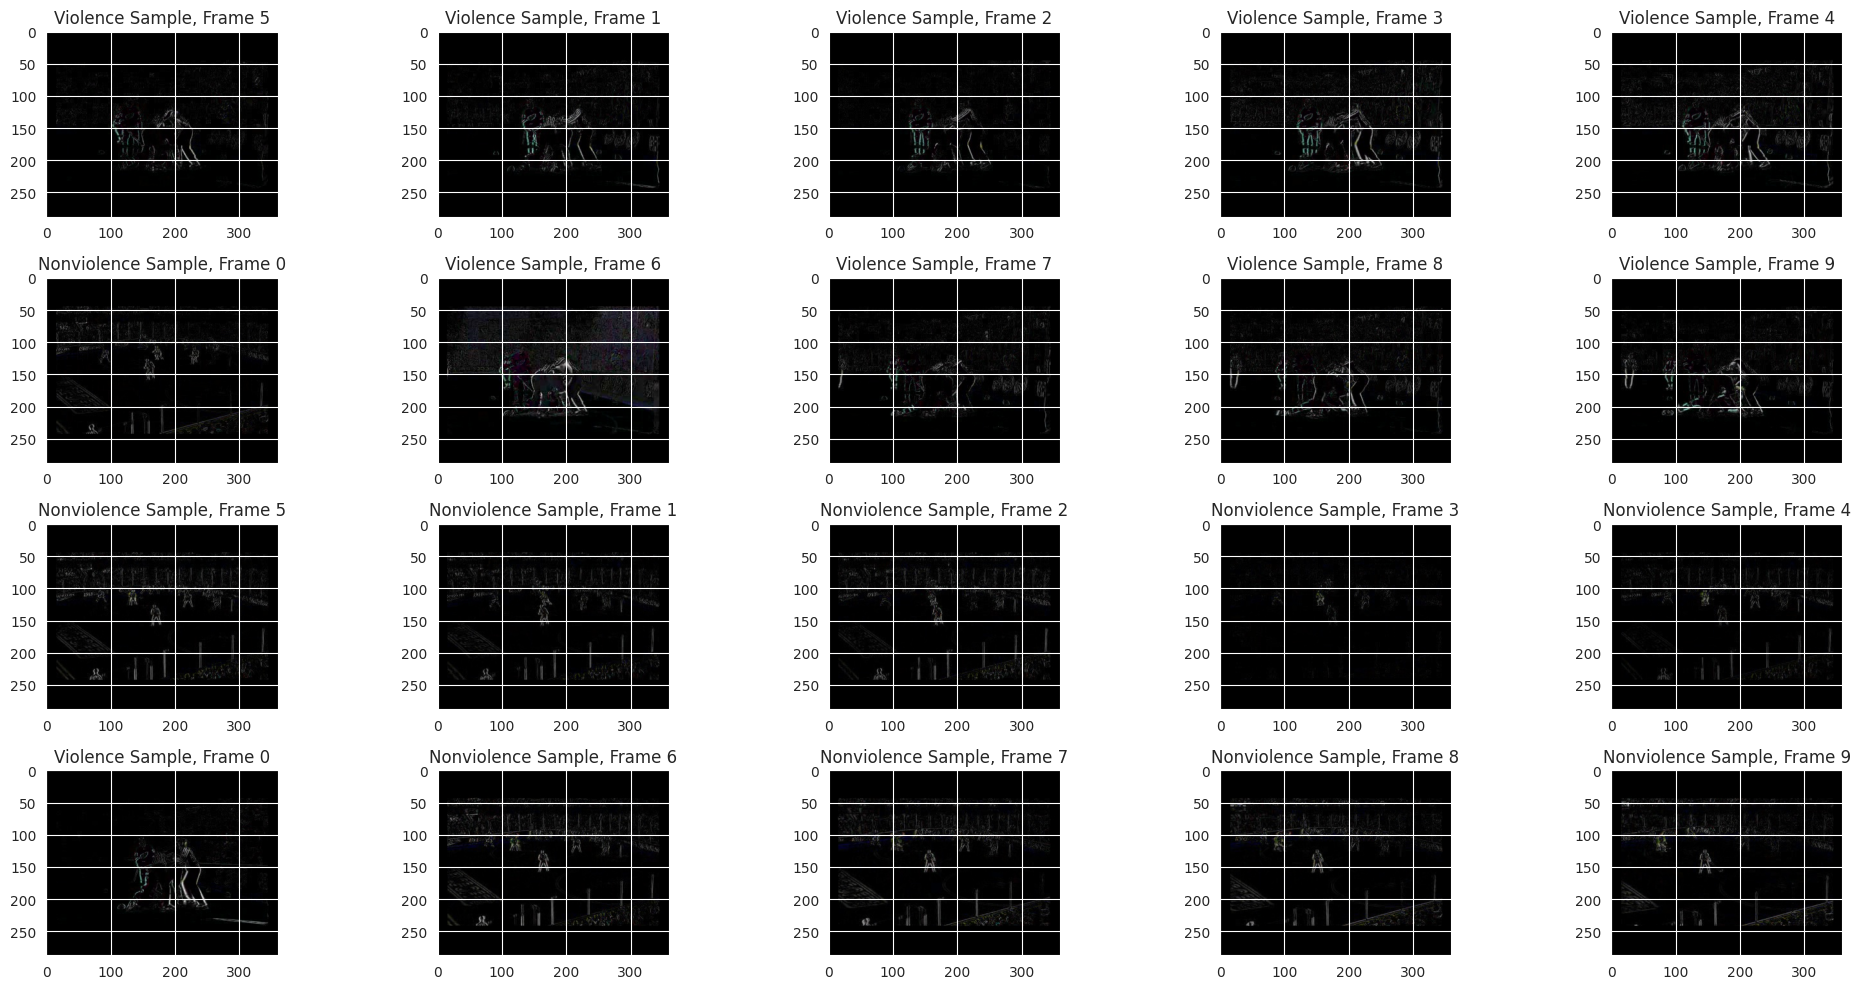

In [22]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20,10))

for i in range(num_frames):
    example_path = os.path.join(violence_sample, f'subtractional_result_{i}.jpg')
    example = cv2.imread(example_path)
    example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
    axs[(i-1)//5][i%5].imshow(example)
    axs[(i-1)//5][i%5].set_title(f'Violence Sample, Frame {i}')

    example_path = os.path.join(nonviolence_sample, f'subtractional_result_{i}.jpg')
    example = cv2.imread(example_path)
    example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
    axs[2 + (i-1)//5][i%5].imshow(example)
    axs[2 + (i-1)//5][i%5].set_title(f'Nonviolence Sample, Frame {i}')

plt.tight_layout()
plt.show()